In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt

- 이상한 프로토콜 없애고, 얇은 애들만 남기고
- 너무 작은 녀석들은 없애고 (max diameter < 2mm  = area < 8mm^3)
- 너무 큰 녀석들은 testset 에서는 제외 
- 나눠진 분포 상에서 S, L은 크기와 병변 개수가 고루 분포하도록 되었는지 

### Set DataFrames

- data_info : lesion 별 정보를 담은 pd.DataFrame
- voxel_size_df : case 별 voxel size를 담은 pd.DataFrame

In [3]:
base_dir = '/workspace/BoneMeta'
img_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')

data_info_path = '/workspace/BoneMeta_raw/data_info.csv'

In [4]:
img_files = os.listdir(img_dir)
label_files = os.listdir(label_dir)
print(len(set(img_files)-set(label_files)), 
len(set(label_files)-set(img_files)))

0 0


In [5]:
def case_to_file(case):
    return case + '.npy'

def file_to_case(file):
    return file.split('.')[0]

In [6]:
data_info = pd.read_csv(data_info_path)
print(
f'''
data info shape = {data_info.shape}, 
Unique case number = {data_info.Case.unique().size}
Cases per lesion type 
 S : {data_info.loc[data_info['Lesion Type']=='S'].Case.unique().size}
 L : {data_info.loc[data_info['Lesion Type']=='L'].Case.unique().size}
 M : {data_info.loc[data_info['Lesion Type']=='M'].Case.unique().size}
 
Different case names: 
  Folder - CSV = {set(os.listdir('/workspace/BoneMeta_raw/data')) - set(data_info.Case.unique())}
  CSV - Folder = {set(data_info.Case.unique()) - set(os.listdir('/workspace/BoneMeta_raw/data'))}
'''
)
print('\ndata_info')
data_info.head()


data info shape = (3176, 13), 
Unique case number = 310
Cases per lesion type 
 S : 228
 L : 170
 M : 119
 
Different case names: 
  Folder - CSV = set()
  CSV - Folder = set()


data_info


,Case,Lesion Type,Lesion Location,I/V,File Name,Lesion Size,Background Size,Original Shape,1mm Resized Shape,1 Resized Shape,Original Center,1mm Resized Center,1 Resized Center
0,000002_20180829_chest,M,T10,I,lesionAnnot3D-004,3449,104854151,"[512, 512, 400]","[377, 377, 400]","(512, 512, 543)","[256, 322, 266]","[188, 237, 266]","[256, 322, 361]"
1,000005_20181202_abdomen,L,L5,V,lesionAnnot3D-001,34062,37976818,"[512, 512, 145]","[323, 323, 435]","(512, 512, 230)","[298, 298, 92]","[188, 188, 276]","[298, 298, 146]"
2,000009_20180417_chest,S,C7-1,V,lesionAnnot3D-001,2299,89126661,"[512, 512, 340]","[378, 378, 340]","(512, 512, 461)","[263, 308, 8]","[194, 227, 8]","[263, 308, 11]"
3,000009_20180417_chest,S,C7-2,I,lesionAnnot3D-002,872,89128088,"[512, 512, 340]","[378, 378, 340]","(512, 512, 461)","[278, 290, 19]","[205, 214, 19]","[278, 290, 26]"
4,000009_20180417_chest,S,T1-2,I,lesionAnnot3D-004,1242,89127718,"[512, 512, 340]","[378, 378, 340]","(512, 512, 461)","[285, 297, 39]","[210, 219, 39]","[285, 297, 53]"


In [7]:
import pandas as pd
import os, json

BASE_DIR = '/workspace/BoneMeta_raw'
JSON_DIR = os.path.join(BASE_DIR, 'json')

SMALL_Z_CRITERIA = 1.5 #mm
CASE_NAMES = os.listdir(JSON_DIR)

def get_json_file(case_name):
    json_path = os.path.join(JSON_DIR, case_name, 'lesionAnnot3D.json')
    return json.load(open(json_path))

def get_voxel_size(json):
    size_string = json['volumeInfo']['voxelResolution_mm']
    size_list = size_string.split(' x ')
    return tuple([float(size) for size in size_list])

voxel_size_df = pd.DataFrame([(case, *get_voxel_size(get_json_file(case))) for case in CASE_NAMES], columns=['case', 'voxel_x', 'voxel_y', 'voxel_z'])
print('voxel_size_df')
voxel_size_df.head()

voxel_size_df


,case,voxel_x,voxel_y,voxel_z
0,000251_20190703_chest,0.560547,0.560547,1.0
1,000356_20191024_chest,0.621094,0.621094,1.0
2,000350_20190927_chest,0.589844,0.589844,1.0
3,000397_20200214_chest,0.613281,0.613281,1.0
4,BH005_20170701_abdomen,0.646484,0.646484,1.0


### 제외할 케이스들 
- 이상한 프로토콜 없애고, 얇은 애들만 남기고

In [8]:
img_file_series = pd.Series(img_files)
abd_chest_idx = img_file_series.str.contains('chest|abd|kidney|liver', case=False)
special_protocol_cases = img_file_series.loc[~abd_chest_idx].values
special_protocol_cases.sort()
special_protocol_cases

array(['000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy',
       '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy',
       '000316_20190715_Spine^L_SPINE (Adult).npy',
       '000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy',
       '000400_20200201_CT Biliary (contrast).npy',
       '000401_20200201_T-Spine+3D CT (noncontrast).npy',
       'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult).npy',
       'BH027_20191001_L-spine CT (3D).npy',
       'BH030_20160101_T-L spine (3D).npy',
       'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy',
       'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2).npy',
       'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy',
       'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy',
       'BH041_20190201_C-T-L Spine (3D).npy',
       'BH042_20180801_C-T-L Spine (3D).npy',
       'SN032_20190401_T spine CT pre contr.npy',
       'SN040_20170201_CT Neck (contrast).npy'

```'000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', - 포함 가능  => O.K.
'000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', - 301 의 8월 26일 chest CT가 있는데.. 꼭 포함해야할까?  => 포함
'000316_20190715_Spine^L_SPINE (Adult).npy', - abd precontrast 로 포함 가능할듯? => 포함
'000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy', - 목 부분이 너무 많은 것 같은데 빼야할까?  => 포함하는데 Train으로 하는 것으로 하면 어떨까? 아니면 목부분을 자를 수 있으면 좋고.
'000400_20200201_CT Biliary (contrast).npy', - 포함, => O.K.
'000401_20200201_T-Spine+3D CT (noncontrast).npy',- 제외 => O.K
'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult).npy',- 제외=> O.K
'BH027_20191001_L-spine CT (3D).npy',- 제외 => O.K
'BH030_20160101_T-L spine (3D).npy',- 제외 => O.K
'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy',- 포함 => O.K
'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2).npy', - 제외 => O.K
'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', - 다리 들어가기 전에만 자를까 싶기도 => O.K
'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy' - 포함 가능한데 병변이 너무 작긴 함.  => 제외
'BH041_20190201_C-T-L Spine (3D).npy', - 제외 => O.K
'BH042_20180801_C-T-L Spine (3D).npy', - 제외 => O.K
'SN032_20190401_T spine CT pre contr.npy', - 제외하는게 나을듯?  => O.K
'SN040_20170201_CT Neck (contrast).npy', - 제외? => O.K
'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy' - 포함 => O.K```

In [9]:
# 301은 무조건 train
# 000391 목자르기 or train
# 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', 에서 다리 자르기 

In [10]:
exclusions = [
       '000401_20200201_T-Spine+3D CT (noncontrast).npy',
       'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult).npy',
       'BH027_20191001_L-spine CT (3D).npy',
       'BH030_20160101_T-L spine (3D).npy',
       'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2).npy',
       'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy',
       'BH041_20190201_C-T-L Spine (3D).npy',
       'BH042_20180801_C-T-L Spine (3D).npy',
       'SN032_20190401_T spine CT pre contr.npy',
       'SN040_20170201_CT Neck (contrast).npy']

In [11]:
included_files = list(set(img_files) - set(exclusions))
included_files.__len__()

300

In [12]:
included_files[:5]

['BH037_20171101_abdomen.npy',
 'BH054_20191122_abdomen.npy',
 'SN002_20190801_chest.npy',
 'BH016_20151001_abdomen.npy',
 '000291_20190718_chest.npy']

#### Select thick sections

In [13]:
thick_idx = voxel_size_df.voxel_z >= SMALL_Z_CRITERIA
thick_cases = voxel_size_df.case[thick_idx]
thick_cases.shape

(65,)

In [16]:
thick_files = [case_to_file(case) for case in thick_cases]

In [17]:
using_thick_files = list(set(included_files).intersection(set(thick_files)))
len(using_thick_files)

63

In [18]:
using_thick_files[:5]

['SN059_20170501_chest.npy',
 '000280_20190625_CT Liver (contrast).npy',
 'SN051_20170401_abdomen.npy',
 'SN046_20170601_abdomen.npy',
 '000282_20190410_abdomen.npy']

### 병변들 크기 확인 

In [19]:
voxel_size_df['voxel_volume'] = voxel_size_df.voxel_x * voxel_size_df.voxel_y * voxel_size_df.voxel_z

In [20]:
set(data_info.Case.unique()) == set(voxel_size_df.case)

True

In [21]:
voxel_size_db = voxel_size_df.set_index('case')

In [22]:
def get_case_voxel_volume(df_row):
    case = df_row.Case
    vox_vol = voxel_size_db.loc[case].voxel_volume
    return vox_vol

In [23]:
data_info['Voxel Volume'] = data_info.apply(get_case_voxel_volume, axis=1)
data_info['Lesion Volume'] = data_info['Lesion Size'] * data_info['Voxel Volume']

<AxesSubplot:>

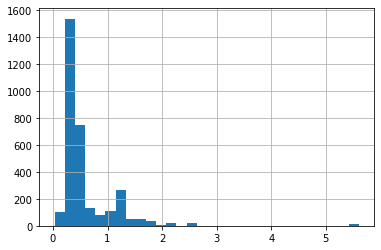

In [24]:
data_info['Voxel Volume'].hist(bins=30)

<AxesSubplot:>

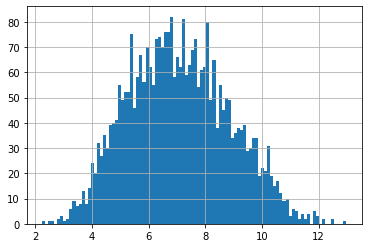

In [25]:
data_info['Lesion Volume'].apply(np.log).hist(bins=100)

In [26]:
data_info['Lesion Volume'].nsmallest(10)

764      9.382044
923     11.779220
861     13.959279
887     16.419519
2833    17.324594
680     17.948259
585     19.149871
594     19.149871
993     21.074369
376     22.508463
Name: Lesion Volume, dtype: float64

In [27]:
data_info.iloc[764]

Case                  000270_20190608_chest
Lesion Type                               S
Lesion Location                      T11-12
I/V                                       V
File Name                 lesionAnnot3D-122
Lesion Size                              23
Background Size                    82575337
Original Shape              [512, 512, 315]
1mm Resized Shape           [327, 327, 315]
1 Resized Shape             (512, 512, 493)
Original Center             [239, 344, 240]
1mm Resized Center          [153, 220, 240]
1 Resized Center            [239, 344, 376]
Voxel Volume                       0.407915
Lesion Volume                       9.38204
Name: 764, dtype: object

In [28]:
data_info['Lesion Volume'].nlargest(10)

795     434378.833181
1378    277525.777738
2596    270932.565685
2514    198764.875461
2996    192249.867866
2125    157819.365850
3061    153514.569972
2294    150858.329647
3074    144709.819284
2940    140322.164369
Name: Lesion Volume, dtype: float64

In [29]:
35*35*35*4/3*3.141592 # 직경 7cm 짜리 구의 부피 -> 이정도 하면 5케이스정도 되겠다. 

179594.34266666666

In [30]:
data_info.iloc[[795, 1378, 2596, 2514, 2996]].Case.values

array(['000273_20190531_chest', '000325_20190919_chest',
       'SN002_20190801_abdomen', 'BH069_20200505_chest',
       'SN029_20200301_abdomen'], dtype=object)

너무 큰 병변 - 기준 = $180000 mm^3$ = 직경 7cm 구의 부피 

['000273_20190531_chest', '000325_20190919_chest',
       'SN002_20190801_abdomen', 'BH069_20200505_chest',
       'SN029_20200301_abdomen']

너무 작은 기준은 안해도 될지? 

### Split train/val/test
- 너무 큰 녀석들은 testset 에서는 제외
- 나눠진 분포 상에서 S, L은 크기와 병변 개수가 고루 분포하도록 되었는지

In [149]:
def get_id(case_or_file):
    return case_or_file.split('_')[0]

In [150]:
len(using_thick_files)

63

In [151]:
cases_having_large_lesions = ['000273_20190531_chest', '000325_20190919_chest', 'SN002_20190801_abdomen', 'BH069_20200505_chest', 'SN029_20200301_abdomen']
files_having_large_lesions = [case_to_file(case) for case in cases_having_large_lesions]

In [152]:
# 이것들은 무조건 train으로 포함. 
train_only_files = ['000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy',
'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy',
'000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', 
'000301_20190801_abdomen.npy', '000301_20190827_chest.npy'
]

In [153]:
# 사용할 파일 중, 위의 파일들과 patient_id가 겹치는 것은 train으로 넣어줘야함. 
pre_to_train_files = files_having_large_lesions + train_only_files
pre_to_train_ids = [get_id(file) for file in pre_to_train_files]
to_train_idx = pd.Series(using_thick_files).str.startswith(tuple(pre_to_train_ids))
to_train_files = list(pd.Series(using_thick_files)[to_train_idx].values)
to_train_files

['SN002_20190801_abdomen.npy', 'SN029_20200301_abdomen.npy']

In [154]:
splitting_files = list(set(using_thick_files) - set(to_train_files))
len(splitting_files)

61

In [155]:
# 쪼갤 파일은 splitting_files,
# id base 로 쪼개자. 
personal_ids = [get_id(file_name) for file_name in splitting_files]
unique_ids = list(set(personal_ids))
random_order_ids = np.random.permutation(unique_ids) 
len(random_order_ids)

50

In [156]:
first_point = int(len(random_order_ids)*0.68)
second_point = int(len(random_order_ids)*0.85)

In [157]:
train_ids = random_order_ids[:first_point]
val_ids = random_order_ids[first_point:second_point]
test_ids = random_order_ids[second_point:]

In [158]:
def get_files_by_ids(cases, ids):
    case_by_id_idx = pd.Series(cases).str.startswith(tuple(ids))
    return list(pd.Series(cases)[case_by_id_idx])

In [159]:
train_files = get_files_by_ids(splitting_files, train_ids)
val_files = get_files_by_ids(splitting_files, val_ids)
test_files = get_files_by_ids(splitting_files, test_ids)

In [160]:
print(f"""
train files: {len(train_files)}
val files: {len(val_files)}
test files: {len(test_files)}""")


train files: 42
val files: 9
test files: 10


In [161]:
train_files_final = train_files + to_train_files
len(train_files_final)

44

### Final dataset

In [162]:
print(f"""
TRAIN_FILES = {train_files_final}

VAL_FILES = {val_files}

TEST_FILES = {test_files}
""")


TRAIN_FILES = ['SN059_20170501_chest.npy', 'SN051_20170401_abdomen.npy', 'SN046_20170601_abdomen.npy', '000282_20190410_abdomen.npy', '000270_20190601_abdomen.npy', '000317_20190720_CT Liver (contrast).npy', 'SN019_20190801_abdomen.npy', '000262_20190319_abdomen.npy', 'SN015_20190901_abdomen.npy', 'SN020_20190801_abdomen.npy', 'SN031_20160501_abdomen.npy', 'SN032_20190501_abdomen.npy', 'SN034_20200101_chest.npy', '000269_20181214_abdomen.npy', 'SN004_20190801_abdomen.npy', 'SN034_20200101_abdomen.npy', '000019_20190601_abdomen.npy', 'SN009_20190801_chest.npy', 'SN039_20181001_abdomen.npy', 'SN042_20170901_abdomen.npy', '000269_20190325_abdomen.npy', 'SN049_20170901_abdomen.npy', 'SN049_20170901_chest.npy', 'SN005_20191001_abdomen.npy', 'SN011_20180401_chest.npy', 'SN039_20181001_chest.npy', '000304_20190124_CT Liver (contrast).npy', 'SN020_20190801_chest.npy', 'SN017_20190801_abdomen.npy', 'SN010_20190801_CT Liver+Pelvis(contrast).npy', 'SN025_20200401_abdomen.npy', '000005_20181202_a

TRAIN_FILES = ['000280_20190625_CT Liver (contrast).npy', 'SN051_20170401_abdomen.npy', 'SN046_20170601_abdomen.npy', '000282_20190410_abdomen.npy', '000317_20190720_CT Liver (contrast).npy', 'SN019_20190801_abdomen.npy', 'SN050_20170401_chest.npy', 'SN014_20190901_abdomen.npy', '000010_20181214_abdomen.npy', 'SN015_20190901_abdomen.npy', 'SN020_20190801_abdomen.npy', 'SN031_20160501_abdomen.npy', 'SN043_20170701_chest.npy', 'SN044_20160601_CT Liver+Pelvis(contrast).npy', '000269_20181214_abdomen.npy', 'SN004_20190801_abdomen.npy', 'SN045_20170201_chest.npy', '000269_20190325_abdomen.npy', 'SN049_20170901_abdomen.npy', 'SN049_20170901_chest.npy', 'SN005_20191001_abdomen.npy', 'SN001_20190901_abdomen.npy', '000012_20181212_abdomen.npy', '000304_20190124_CT Liver (contrast).npy', '000025_20180808_abdomen.npy', 'SN020_20190801_chest.npy', 'SN045_20170201_abdomen.npy', 'SN016_20190901_abdomen.npy', 'SN014_20190901_chest.npy', 'SN010_20190801_CT Liver+Pelvis(contrast).npy', 'SN025_20200401_abdomen.npy', 'SN055_20170301_abdomen.npy', 'SN040_20170201_abdomen.npy', 'SN018_20190801_abdomen.npy', 'SN030_20191101_abdomen.npy', 'SN007_20190801_abdomen.npy', '000286_20190710_chest.npy', '000269_20181016_abdomen.npy', 'SN028_20160801_abdomen.npy', 'SN048_20170801_chest.npy', 'SN018_20190801_chest.npy', 'SN013_20190401_abdomen.npy', 'SN002_20190801_abdomen.npy', 'SN029_20200301_abdomen.npy']

VAL_FILES = ['000270_20190601_abdomen.npy', '000262_20190319_abdomen.npy', 'SN034_20200101_chest.npy', 'SN034_20200101_abdomen.npy', '000019_20190601_abdomen.npy', 'SN042_20170901_abdomen.npy', 'SN035_20180101_chest.npy', '000251_20190429_abdomen.npy']

TEST_FILES = ['SN059_20170501_chest.npy', 'SN032_20190501_abdomen.npy', 'SN009_20190801_chest.npy', 'SN039_20181001_abdomen.npy', 'SN012_20150801_abdomen.npy', 'SN011_20180401_chest.npy', 'SN039_20181001_chest.npy', 'SN017_20190801_abdomen.npy', '000005_20181202_abdomen.npy', 'SN009_20190801_abdomen.npy', 'SN011_20180401_abdomen.npy']

# Check data distribution 

In [163]:
exec(f"""
TRAIN_FILES = {train_files_final}

VAL_FILES = {val_files}

TEST_FILES = {test_files}
""")

In [164]:
train_idx = data_info.Case.isin([file_to_case(file) for file in TRAIN_FILES])
val_idx = data_info.Case.isin([file_to_case(file) for file in VAL_FILES])
test_idx = data_info.Case.isin([file_to_case(file) for file in TEST_FILES])

In [165]:
data_info_train = data_info.loc[train_idx]
data_info_val = data_info.loc[val_idx]
data_info_test = data_info.loc[test_idx]

### Lesion types

In [166]:
def show_lesion_type_num(data_info, title):
    print(
    f'''
    {title}
    data shape = {data_info.shape}, 
    Unique case number = {data_info.Case.unique().size}
    Cases per lesion type 
     S : {data_info.loc[data_info['Lesion Type']=='S'].Case.unique().size}
     L : {data_info.loc[data_info['Lesion Type']=='L'].Case.unique().size}
     M : {data_info.loc[data_info['Lesion Type']=='M'].Case.unique().size}

    I/V ratio = {data_info.loc[data_info['I/V']=='I'].shape[0]} / {data_info.loc[data_info['I/V']=='V'].shape[0]}
    '''
    )

In [167]:
show_lesion_type_num(data_info_train, 'Train')
show_lesion_type_num(data_info_val, 'Validation')
show_lesion_type_num(data_info_test, 'Test')


    Train
    data shape = (543, 15), 
    Unique case number = 44
    Cases per lesion type 
     S : 31
     L : 27
     M : 12

    I/V ratio = 192 / 351
    

    Validation
    data shape = (81, 15), 
    Unique case number = 9
    Cases per lesion type 
     S : 6
     L : 7
     M : 3

    I/V ratio = 28 / 53
    

    Test
    data shape = (73, 15), 
    Unique case number = 10
    Cases per lesion type 
     S : 9
     L : 2
     M : 4

    I/V ratio = 13 / 60
    


### Lesion size 

In [168]:
def show_hist(data_info, ax, type="All", log=False, n_bin = 20, title=''):
    if ax is None:
        ax = plt.gca()
    if log:
        if type == 'All':
            ax.hist(data_info['Lesion Volume'].apply(np.log), bins = n_bin, density=True)
        else:
            ax.hist(data_info.loc[data_info['Lesion Type']==type]['Lesion Volume'].apply(np.log), bins = n_bin, density=True)
    else:
        if type == 'All':
            ax.hist(data_info['Lesion Volume'], bins = n_bin, density=True)
        else:
            ax.hist(data_info.loc[data_info['Lesion Type']==type]['Lesion Volume'], bins = n_bin, density=True)
    
    ax.set_title(label = title)
    return ax

In [169]:
def show_lesion_volume_per_type(data_info):
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(16,4), sharey= True,sharex= True)
    show_hist(data_info, axes[0], title='log All size', log=True)
    show_hist(data_info, axes[1], type='S', title='log S size', log=True)
    show_hist(data_info, axes[2], type='L', title='log L size', log=True)
    show_hist(data_info, axes[3], type='M', title='log M size', log=True)
    fig.show()

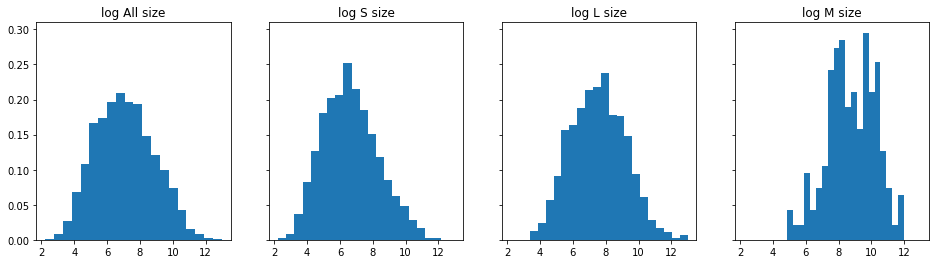

In [170]:
show_lesion_volume_per_type(data_info)

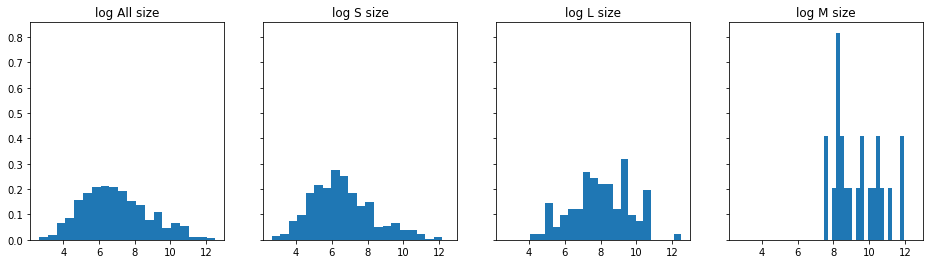

In [171]:
show_lesion_volume_per_type(data_info_train)

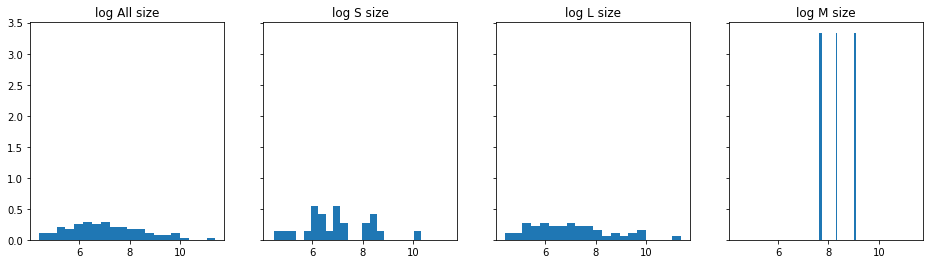

In [172]:
show_lesion_volume_per_type(data_info_val)

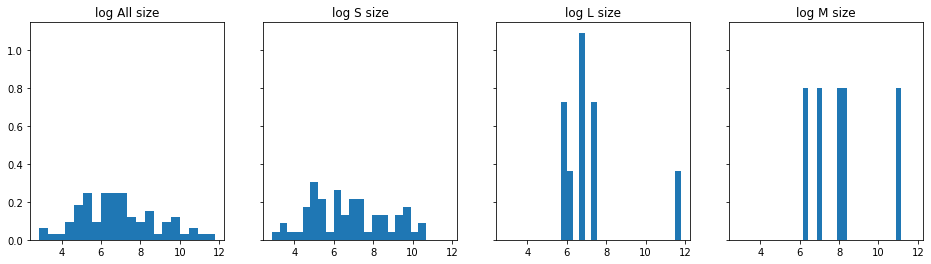

In [173]:
show_lesion_volume_per_type(data_info_test)

In [128]:
def print_lesion_volumes(data_info):
    print(
f"""
Lesion info 
{data_info['Lesion Volume'].describe()}
""")

In [129]:
print_lesion_volumes(data_info)


Lesion info 
count      3176.000000
mean       5624.488986
std       16985.261917
min           9.382044
25%         315.352937
50%        1093.596892
75%        4035.549243
max      434378.833181
Name: Lesion Volume, dtype: float64



In [130]:
print_lesion_volumes(data_info_train)


Lesion info 
count       477.000000
mean       6900.328854
std       21623.084140
min          13.959279
25%         352.249146
50%        1076.192395
75%        3608.921890
max      270932.565685
Name: Lesion Volume, dtype: float64



In [131]:
print_lesion_volumes(data_info_val)


Lesion info 
count        49.000000
mean      14296.058509
std       24370.543376
min          42.797209
25%        1988.181603
50%        4940.074942
75%       14039.305567
max      134516.439585
Name: Lesion Volume, dtype: float64



In [132]:
print_lesion_volumes(data_info_test)


Lesion info 
count      171.000000
mean      1706.527210
std       4520.017283
min         19.149871
25%        158.062700
50%        397.040664
75%        944.604479
max      29701.223910
Name: Lesion Volume, dtype: float64

